In [3]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [4]:
# Cargar CSV
from google.colab import files
import pandas as pd
import os

print(" Sube tu archivo CSV desde tu computadora.")
uploaded = files.upload()  # abre el cuadro de selección

if not uploaded:
    raise RuntimeError("No se subió ningún archivo.")

# Tomamos el primer archivo subido
fname = next(iter(uploaded.keys()))

# Guardarlo en /content para reutilizarlo fácilmente
CSV_PATH = f"/content/{fname}"
with open(CSV_PATH, "wb") as f:
    f.write(uploaded[fname])

# Leer el CSV
try:
    df_raw = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="utf-8")
except UnicodeDecodeError:
    df_raw = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="latin-1")

print(" Cargado:", CSV_PATH)
print("Forma (filas, columnas):", df_raw.shape)
df_raw.head()


 Sube tu archivo CSV desde tu computadora.


Saving ecobici_2024_enero.csv.crdownload to ecobici_2024_enero.csv.crdownload
 Cargado: /content/ecobici_2024_enero.csv.crdownload
Forma (filas, columnas): (1558100, 9)


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha Arribo,Hora_Arribo
0,M,48.0,3371879,113,31/12/2023,23:21:52,659,01/01/2024,00:00:02
1,F,26.0,7033434,281,31/12/2023,23:46:02,047,01/01/2024,00:00:02
2,F,37.0,7169857,015,31/12/2023,23:51:57,217,01/01/2024,00:00:49
3,F,30.0,6368211,555,31/12/2023,23:53:10,008,01/01/2024,00:02:39
4,M,30.0,5136924,555,31/12/2023,23:52:53,008,01/01/2024,00:02:45


In [7]:

rename_map = {
    "Genero_Usuario": "genero",
    "Edad_Usuario": "edad",
    "Bici": "bici_id",
    "Ciclo_Estacion_Retiro": "estacion_retiro_id",
    "Fecha_Retiro": "fecha_retiro",
    "Hora_Retiro": "hora_retiro",
    "Ciclo_EstacionArribo": "estacion_arribo_id",
    "Fecha Arribo": "fecha_arribo",
    "Hora_Arribo": "hora_arribo",
}
df = df_raw.rename(columns=rename_map).copy()

# Tipos numéricos
for col in ["edad", "bici_id", "estacion_retiro_id", "estacion_arribo_id"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

print(df.dtypes)
df.head(3)

genero                object
edad                   Int64
bici_id                Int64
estacion_retiro_id     Int64
fecha_retiro          object
hora_retiro           object
estacion_arribo_id     Int64
fecha_arribo          object
hora_arribo           object
dtype: object


,genero,edad,bici_id,estacion_retiro_id,fecha_retiro,hora_retiro,estacion_arribo_id,fecha_arribo,hora_arribo
0,M,48,3371879,113,31/12/2023,23:21:52,659,01/01/2024,00:00:02
1,F,26,7033434,281,31/12/2023,23:46:02,47,01/01/2024,00:00:02
2,F,37,7169857,15,31/12/2023,23:51:57,217,01/01/2024,00:00:49


In [8]:
fmt = "%d/%m/%Y %H:%M:%S"  # dd/mm/yyyy HH:MM:SS

df["inicio"] = pd.to_datetime(
    df["fecha_retiro"].astype(str) + " " + df["hora_retiro"].astype(str),
    format=fmt, errors="coerce"
)
df["fin"] = pd.to_datetime(
    df["fecha_arribo"].astype(str) + " " + df["hora_arribo"].astype(str),
    format=fmt, errors="coerce"
)

df["duracion_min"] = (df["fin"] - df["inicio"]).dt.total_seconds() / 60

# Filtros: quitar negativos y viajes absurdamente largos (>12h)
mask_valid = (
    df["duracion_min"].notna() &
    (df["duracion_min"] >= 0) &
    (df["duracion_min"] <= 12*60)
)
df = df[mask_valid].copy().reset_index(drop=True)

In [9]:
#variables

df["fecha"] = df["inicio"].dt.date
df["anio"]  = df["inicio"].dt.year
df["mes"]   = df["inicio"].dt.month
df["dia"]   = df["inicio"].dt.day
df["hora"]  = df["inicio"].dt.hour


dias_es = {0:"Lunes",1:"Martes",2:"Miércoles",3:"Jueves",4:"Viernes",5:"Sábado",6:"Domingo"}
df["dia_semana"] = df["inicio"].dt.dayofweek.map(dias_es)

df[["fecha","hora","dia_semana","duracion_min"]].head(7)

,fecha,hora,dia_semana,duracion_min
0,2023-12-31,23,Domingo,38.166667
1,2023-12-31,23,Domingo,14.000000
2,2023-12-31,23,Domingo,8.866667
3,2023-12-31,23,Domingo,9.483333
4,2023-12-31,23,Domingo,9.866667
5,2023-12-31,23,Domingo,4.083333
6,2023-12-31,23,Domingo,22.100000


In [10]:
# KPI
total_viajes     = len(df)
dur_media        = df["duracion_min"].mean()
dur_mediana      = df["duracion_min"].median()
edad_media       = df["edad"].astype("float").mean() if "edad" in df.columns else np.nan
genero_dist      = df["genero"].value_counts(dropna=False) if "genero" in df.columns else None

print(f"Total de viajes válidos: {total_viajes:,}")
print(f"Duración media (min): {dur_media:,.2f}")
print(f"Duración mediana (min): {dur_mediana:,.2f}")
print("Edad media (años):", round(edad_media, 2) if not np.isnan(edad_media) else "N/D")
if genero_dist is not None:
    print("\nDistribución por género:")
    print(genero_dist)

Total de viajes válidos: 1,558,015
Duración media (min): 15.33
Duración mediana (min): 12.28
Edad media (años): 33.95

Distribución por género:
genero
M    1087294
F     439496
O      31216
?          9
Name: count, dtype: int64


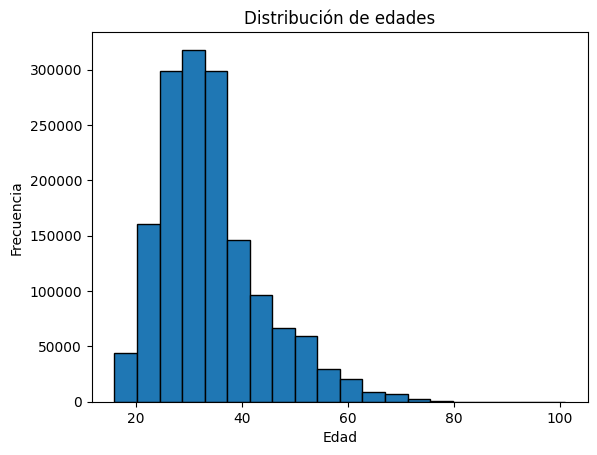

In [11]:
#histogrma de edades

import matplotlib.pyplot as plt

if "edad" in df.columns:
    plt.figure()
    df["edad"].dropna().astype(int).plot(kind="hist", bins=20, edgecolor="black")
    plt.title("Distribución de edades")
    plt.xlabel("Edad")
    plt.ylabel("Frecuencia")
    plt.show()

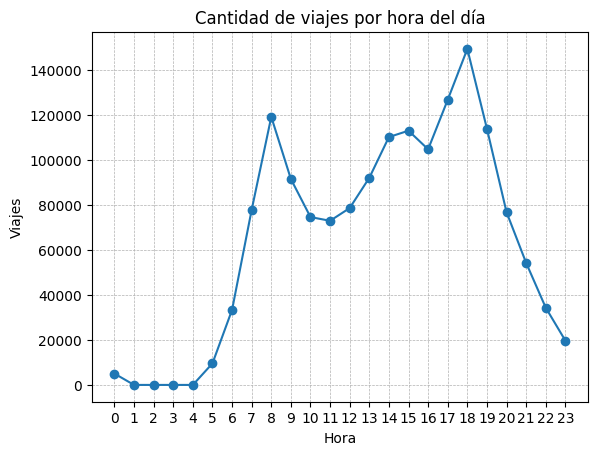

In [12]:
# viajes por hora del día
viajes_por_hora = df.groupby("hora").size().reindex(range(24), fill_value=0)
plt.figure()
viajes_por_hora.plot(kind="line", marker="o")
plt.title("Cantidad de viajes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Viajes")
plt.xticks(range(0,24,1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

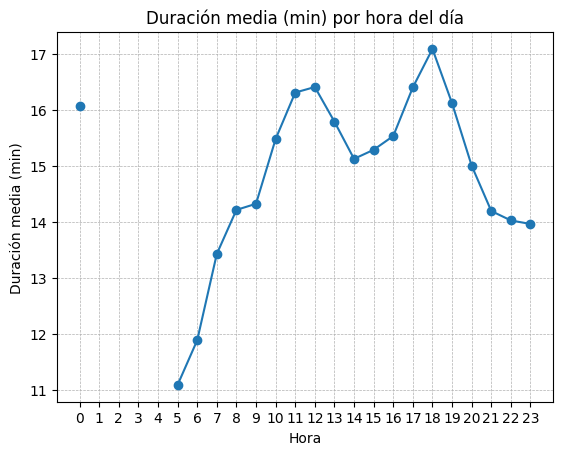

In [13]:
#duracion

duracion_por_hora = df.groupby("hora")["duracion_min"].mean().reindex(range(24), fill_value=np.nan)
plt.figure()
duracion_por_hora.plot(kind="line", marker="o")
plt.title("Duración media (min) por hora del día")
plt.xlabel("Hora")
plt.ylabel("Duración media (min)")
plt.xticks(range(0,24,1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

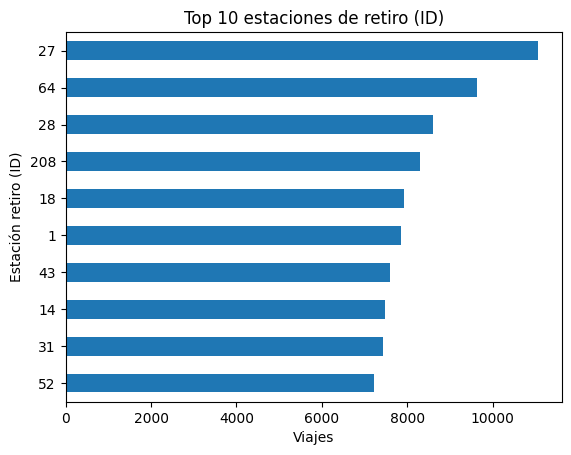

In [15]:
# Top 10 de retiro
if "estacion_retiro_id" in df.columns:
    top_retiro = df["estacion_retiro_id"].value_counts().head(10).sort_values()
    plt.figure()
    top_retiro.plot(kind="barh")
    plt.title("Top 10 estaciones de retiro (ID)")
    plt.xlabel("Viajes")
    plt.ylabel("Estación retiro (ID)")
    plt.show()

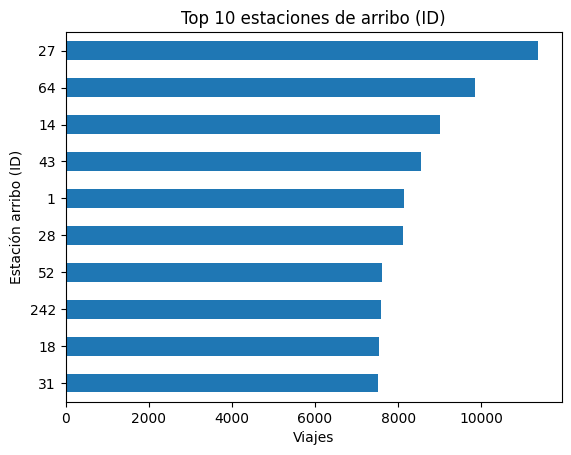

In [16]:
# top 10 de arribo

if "estacion_arribo_id" in df.columns:
    top_arribo = df["estacion_arribo_id"].value_counts().head(10).sort_values()
    plt.figure()
    top_arribo.plot(kind="barh")
    plt.title("Top 10 estaciones de arribo (ID)")
    plt.xlabel("Viajes")
    plt.ylabel("Estación arribo (ID)")
    plt.show()

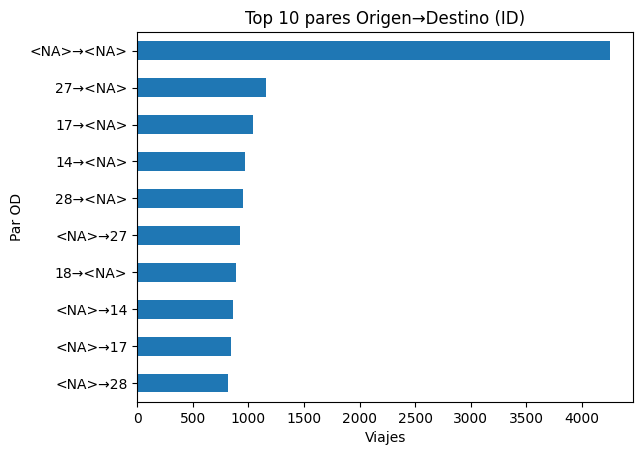

In [17]:
#top 10 origen destino
if {"estacion_retiro_id","estacion_arribo_id"}.issubset(df.columns):
    pares = (
        df.assign(od=df["estacion_retiro_id"].astype(str) + "→" + df["estacion_arribo_id"].astype(str))
          ["od"].value_counts().head(10).sort_values()
    )
    plt.figure()
    pares.plot(kind="barh")
    plt.title("Top 10 pares Origen→Destino (ID)")
    plt.xlabel("Viajes")
    plt.ylabel("Par OD")
    plt.show()

In [18]:
# Exportar dataset limpio
OUTPUT_CSV = "ecobici_2024_enero_limpio.csv"
cols_exportar = [
    "genero","edad","bici_id","estacion_retiro_id","estacion_arribo_id",
    "inicio","fin","duracion_min","anio","mes","dia","hora","dia_semana"
]
cols_exportar = [c for c in cols_exportar if c in df.columns]
df.to_csv(OUTPUT_CSV, index=False, columns=cols_exportar)
print("Guardado:", OUTPUT_CSV)

# Descarga al equipo
from google.colab import files
files.download(OUTPUT_CSV)

Guardado: ecobici_2024_enero_limpio.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>